# Programming Assignment 3
# Problem 2: Model based Collaborative Filtering

## Bringing Imports and Setting File Paths

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from scipy.linalg import sqrtm

In [3]:
DATA_PATH = 'dataset/ml-100k-dataset'
MOVIE_FILENAME = 'u.item'
RATING_FILENAME = 'u.data'

movie_filename_path = os.path.join(DATA_PATH, MOVIE_FILENAME)
rating_filename_path = os.path.join(DATA_PATH, RATING_FILENAME)

## Getting Data from the Files

In [4]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(rating_filename_path, sep='\t', names=r_cols,
                      encoding='latin-1')

In [14]:
print(ratings.head(5).to_string(index=False))
print(ratings.shape)

 user_id  movie_id  rating  unix_timestamp
     196       242       3       881250949
     186       302       3       891717742
      22       377       1       878887116
     244        51       2       880606923
     166       346       1       886397596
(100000, 4)


In [6]:
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv(movie_filename_path, sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

## Splitting into Test and Train
- I am using a custom test and train splitter in order to ensure that in both the datasets, we have entries for all the users.

In [7]:
def get_test_train_split(df, test_ratio):
    users = df['user_id'].unique()
    movies = df['movie_id'].unique()
    
    test = None
    train = None

    for u in users:
        temp = df[df['user_id'] == u]
        # n = len(temp)
        temp_train, temp_test = train_test_split(temp, test_size=0.2)
        # print(temp_test.shape, temp_train.shape)
        if test is not None:
            test = pd.concat([test, temp_test])
            train = pd.concat([train, temp_train])
        else:
            test = temp_test
            train = temp_train
    return test, train

In [8]:
ratings_test, ratings_train = get_test_train_split(ratings, 0.2)

## Converting into User-Item Matrix

In [15]:
user_item_matrix = ratings_train.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix.head(20)
print(user_item_matrix.shape)

(943, 1646)


## SVD algorithm
This also consists the normalization step.

In [11]:
def svd(train, k):
    util_mat = np.array(train)
    mask = np.isnan(util_mat)
    masked_arr = np.ma.masked_array(util_mat, mask)
    item_means = np.mean(masked_arr, axis=0)
    util_mat = masked_arr.filled(item_means)
    x = np.tile(item_means, (util_mat.shape[0], 1))
    util_mat = util_mat - x

    U,s,V = np.linalg.svd(util_mat, full_matrices=False)
    
    s=np.diag(s)
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    
    s_root = sqrtm(s)

    Usk = np.dot(U, s_root)
    skV = np.dot(s_root, V)
    UsV = np.dot(Usk, skV)

    UsV = UsV + x
    return UsV

In [12]:
def rmse(true, pred):
    X = true - pred
    return sum([xi*xi for xi in X])/len(X)

In [16]:
THE_CHOOSEN_USER = 196

## Running SVD for different number of feature decompositions

In [26]:
import time

no_of_features_decomposition = [5,10,15,20,25]


for f in no_of_features_decomposition:
    print("--------------------------------------------------------------------")
    start_time = time.time()
    print("1. Building model starting for " + str(f) + " SVD Projection Dimension ")
    svdout = svd(user_item_matrix, f)
    print("2. Built model for " + str(f) + " SVD Projection Dimension in " + str(time.time() - start_time) + "s")

    pred = []

    print("3. Predictions start...")
    start_time = time.time()
    for _,row in ratings_test.iterrows():
        user = row['user_id']
        item = row['movie_id']
        pred_rating = None
        if item <= len(user_item_matrix.columns):
            pred_rating = svdout[user-1, item-1]
        else:
            pred_rating = np.mean(svdout[user-1,:])
        pred.append(pred_rating)
    print("4. Predictions complete in " + str(time.time() - start_time) + "s for " + str(len(pred)) + " data-points")

    results_df = ratings_test.copy(deep=True)
    results_df.drop(columns=['unix_timestamp'], inplace=True)
    results_df['pred_rating'] = pred
    users = results_df['user_id'].unique()
    results_df.rename(columns={"rating": "actual_rating"}, inplace=True)
    results_df_str = None
    for user in users:
        temp = results_df[results_df['user_id'] == user]
        if results_df_str is None:
            results_df_str = temp.head(1)
        else:
            results_df_str = pd.concat([results_df_str, temp.head(1)])
    
    choosen_user_preds = svdout[THE_CHOOSEN_USER-1, :]
    best_movies = np.flip(np.argsort(choosen_user_preds))
    print("Top 5 movies recommended for the choosen UserID 196 with predicted ratings")
    counter = 1
    for movie in best_movies:
        if counter > 5:
            break
        if ratings[(ratings['movie_id'] == movie+1) & (ratings['user_id'] == THE_CHOOSEN_USER)].shape[0] < 1:
            print(str(counter) + ". " + movies[movies['movie_id'] == movie+1].iloc[0]['title'] + "; Predicted Rating - " + str(choosen_user_preds[movie]))
            counter += 1
    
    print("5. Predictions Output (For 20 unique users)")
    print(results_df_str.head(20).to_string(index=False))

    print("6. RMSE for " + str(f) + " SVD Projection Dimension = " + str(rmse(ratings_test['rating'], pred)))

--------------------------------------------------------------------
1. Building model starting for 5 SVD Projection Dimension 
2. Built model for 5 SVD Projection Dimension in 0.6738145351409912s
3. Predictions start...
4. Predictions complete in 0.7941782474517822s for 20381 data-points
Top 5 movies recommended for the choosen UserID 196 with predicted ratings
1. That Old Feeling (1997); Predicted Rating - 5.0
2. Price Above Rubies, A (1998); Predicted Rating - 5.0
3. Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964); Predicted Rating - 5.0
4. Young Guns II (1990); Predicted Rating - 5.0
5. Damsel in Distress, A (1937); Predicted Rating - 5.0
5. Predictions Output (For 20 unique users)
 user_id  movie_id  actual_rating  pred_rating
     196      1118              4     3.698713
     186       939              5     2.390029
      22        29              1     2.500097
     244      1095              2     2.502977
     166       894              4     3.258764
     

## Plotting graphs

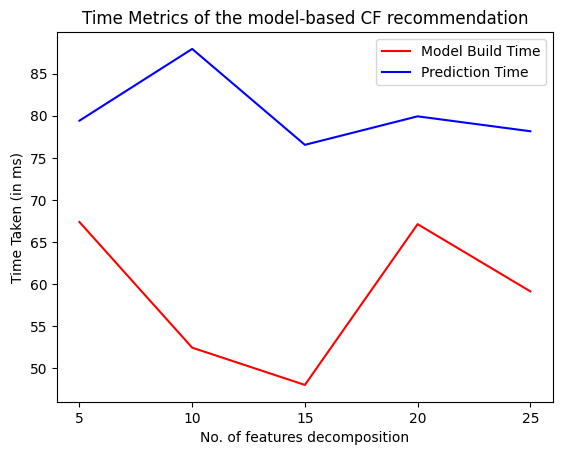

In [35]:
from matplotlib import pyplot as plt

build_time = [67.38145351409912, 52.45695114135742, 48.03004264831543, 67.12355613708496, 59.14216041564941]
pred_time = [79.41782474517822, 87.93885707855225, 76.54550075531006, 79.93218898773193, 78.16145420074463]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xticks(no_of_features_decomposition)
ax.plot(no_of_features_decomposition, build_time, label='Model Build Time', color='r')
ax.plot(no_of_features_decomposition, pred_time, label='Prediction Time', color='b')
ax.set_title("Time Metrics of the model-based CF recommendation")
ax.legend()
ax.set_xlabel("No. of features decomposition")
ax.set_ylabel("Time Taken (in ms)")
fig.savefig('time-measurement.png')

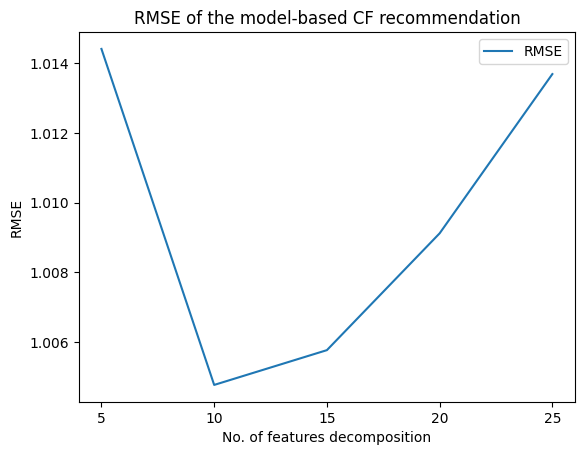

In [36]:
rmse = [1.0144148014980479, 1.0047620221424585, 1.005761104936141, 1.0091169319885724, 1.0136924028513037]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xticks(no_of_features_decomposition)
ax.plot(no_of_features_decomposition, rmse, label='RMSE')
ax.set_title("RMSE of the model-based CF recommendation")
ax.legend()
ax.set_xlabel("No. of features decomposition")
ax.set_ylabel("RMSE")
fig.savefig('rmse.png')
